# Assignment

In [1]:
# Import 

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
'''
    :param p_k1: position of King 1
    :param p_k2: position of King 2
    :param p_q1: position of Queen
    :param s: board
'''
from degree_freedom_queen import *
# return: dfQ1: Degrees of Freedom of the Queen, a_q1: Allowed actions for the Queen, dfQ1_: Squares the Queen is threatening
from degree_freedom_king1 import *
# return: dfK1: Degrees of Freedom of King 1, a_k1: Allowed actions for King 1, dfK1_: Squares the King1 is threatening
from degree_freedom_king2 import *
# return: dfK2: Degrees of freedom for King 2, a_k2: allowed actions for King 2, check: 1 if it is checked, -1 if not

from generate_game import *
'''
This function creates a new chess game with three pieces at random locations. 
The enemy King has no interaction with our King and Queen. Positions range from 0 to 4
    :param size_board:
    :return:
'''

from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[3 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 2 0 0]]
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 1 0]
 [0 2 0 0]
 [0 0 0 0]]
0.0  1
check?  0
dofk2  0


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.192 Number of steps:  7.452


In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
global epsilon_0, beta, gamma, eta
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
    
# RMSprop
rms_alpha = 0.9

# N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 
N_episodes = 1000

alpha = 1/N_episodes

# Flags
change_rewards = [0, 1]
rms_prop = [0, 1]

In [6]:
def Initialize():
    # weights
    global W1, W2, bias_W1, bias_W2
    W1=np.random.uniform(0,1,(N_h,N_in))
    W1=np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
    W2=np.random.uniform(0,1,(N_a,N_h))
    W2=np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))
    # bias
    bias_W1=np.zeros((N_h,))
    bias_W2=np.zeros((N_a,))
    
    # RMSprop
    global avg_delta1, avg_delta2, avg_grad1, avg_grad2
    avg_delta1=np.zeros((N_h,))
    avg_grad1=np.zeros((N_h, N_in))
    avg_delta2=np.zeros((N_a,))
    avg_grad2=np.zeros((N_a, N_h))

In [7]:
def Q_values(X, W1, W2, bias_W1, bias_W2):
    # Neural activation: input layer -> hidden layer
    activation1 = np.dot(W1, X) + bias_W1
    #sig
    out1 = 1 / (1 + np.exp(-activation1))
    # Neural activation: hidden layer -> output layer
    activation2 = np.dot(W2, out1) + bias_W2
    #sig
    Q = 1 / (1 + np.exp(-activation2))
#     print("out1.shape",out1.shape)
    return Q, out1 #output,hidden 

def EpsilonGreedy_Policy(epsilon,Q,a):
    if np.random.uniform(0,1) < epsilon:
        a_agent= a[np.random.randint(len(a))]
    else:
        allowed_Q=[]
        for act in a:
            allowed_Q.append(Q[act])
        best_index=np.argmax(allowed_Q)
        a_agent=a[best_index]

    return a_agent

In [8]:
def AdjustReward(r, done, n_moves):
    if done:
        return 10 if r else 0
    else:
        return 5-(0.5*n_moves)

In [9]:
# import grogress bar
from time import sleep
from tqdm import tqdm

In [10]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

def Train(change_rewards, rms_prop):
    global W1, W2, bias_W1, bias_W2
    global avg_delta1, avg_delta2, avg_grad1, avg_grad2
    
    # Saving variables
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    
    # for n in range(N_episodes):
    for n in tqdm(range(N_episodes)):
        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

        # return self.Board, X, allowed_a
        # allowed_a=np.concatenate([self.a_q1,self.a_k1],0)
        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

        while Done==0:                           ## START THE EPISODE

            a,_=np.where(allowed_a==1)

            # Find the Qvalues
            Q, out1 = Q_values(X, W1, W2, bias_W1, bias_W2)
            # Make an action
            a_agent = EpsilonGreedy_Policy(epsilon_f, Q, a)

            # Add to number of moves for the game
            N_moves_save[n] = N_moves_save[n]+1
            # Exponential moving average of the number of moves per game
            if n > 0:
                N_moves_save[n] = ((1-alpha) * N_moves_save[n-1]) + (alpha*N_moves_save[n])

            #return self.Board, X, allowed_a, R, Done    
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)

            if change_rewards:
                R = AdjustReward(R, Done, N_moves_save[n][0])

            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                #R = 1 checkmate, R=0 draw
                delta2 = (R - Q[a_agent]) * np.heaviside(Q[a_agent], 0)
                grad2 = np.outer(delta2, out1)
                if rms_prop:
                    avg_grad2 = rms_alpha * avg_grad2 + (1-rms_alpha) * np.power(grad2, 2)
                    avg_delta2 = rms_alpha * avg_delta2 + (1-rms_alpha) * np.power(delta2, 2)
                    W2 += (eta/np.sqrt(avg_grad2)) * grad2
                    bias_W2 += (eta/np.sqrt(avg_delta2)) * delta2
                else:
                    W2 += eta * grad2
                    bias_W2 += eta * delta2

                delta1 = np.dot(W2[a_agent], delta2) * np.heaviside(out1, 0)
                grad1 = np.outer(delta1, X)
                if rms_prop:
                    avg_grad1 = rms_alpha * avg_grad1 + (1-rms_alpha) * np.power(grad1, 2)
                    avg_delta1 = rms_alpha * avg_delta1 + (1-rms_alpha) * np.power(delta1, 2)
                    W1 += (eta/np.sqrt(avg_grad1)) * grad1
                    bias_W1 += (eta/np.sqrt(avg_delta1)) * delta1
                else:
                    W1 += eta * grad1
                    bias_W1 += eta * delta1

                #set the reward for the game
                R_save[n] = R
                #exponential moving average of the reward R
                if n > 0:
                    R_save[n] = ((1-alpha) * R_save[n-1]) + (alpha*R_save[n])
                break

            # IF THE EPISODE IS NOT OVER...
            else:

                ## ONLY TO PUT SUMETHING
                PIPPO=1

            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

            # We have: S_next,X_next,allowed_a_next,R,Done
            # q-learning max
            Q_next, _ = Q_values(X_next, W1, W2, bias_W1, bias_W2)
            a,_ = np.where(allowed_a==1)
            Q_max = max(Q_next[a])

            # Backpropagation: output layer -> hidden layer
            delta2 = (R + gamma*Q_max - Q[a_agent]) * np.heaviside(Q[a_agent], 0)
            grad2 = np.outer(delta2, out1)
            if rms_prop:
                avg_grad2 = rms_alpha * avg_grad2 + (1-rms_alpha) * np.power(grad2, 2)
                avg_delta2 = rms_alpha * avg_delta2 + (1-rms_alpha) * np.power(delta2, 2)
                W2 += (eta/np.sqrt(avg_grad2)) * grad2
                bias_W2 += (eta/np.sqrt(avg_delta2)) * delta2
            else:
                W2 += eta * grad2
                bias_W2 += eta * delta2

            # Backpropagation: hidden -> input layer
            delta1 = np.dot(W2[a_agent], delta2) * np.heaviside(out1, 0)
            grad1 = np.outer(delta1, X)
            if rms_prop:
                avg_grad1 = rms_alpha * avg_grad1 + (1-rms_alpha) * np.power(grad1, 2)
                avg_delta1 = rms_alpha * avg_delta1 + (1-rms_alpha) * np.power(delta1, 2)
                W1 += (eta/np.sqrt(avg_grad1)) * grad1
                bias_W1 += (eta/np.sqrt(avg_delta1)) * delta1
            else:
                W1 += eta * grad1
                bias_W1 += eta * delta1

            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    return R_save, N_moves_save

In [11]:
Initialize()
r1, n1 = Train(False, False)

Initialize()
r2, n2 = Train(True, False)

Initialize()
r3, n3 = Train(False, True)

Initialize()
r4, n4 = Train(True, True)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\littl\AppData\Local\Temp/ipykernel_3468/4113690901.py:111: RuntimeWarning: divide by zero encountered in true_divide
  W1 += (eta/np.sqrt(avg_grad1)) * grad1
C:\Users\littl\AppData\Local\Temp/ipykernel_3468/4113690901.py:111: RuntimeWarning: invalid value encountered in multiply
  W1 += (eta/np.sqrt(avg_grad1)) * grad1
100%|██████████| 1000/1000 [01:12<00:00, 13.74it/s]


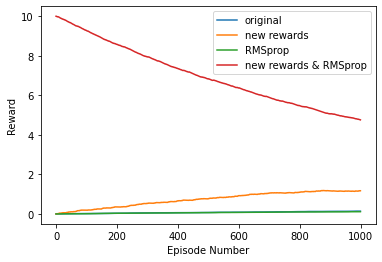

In [12]:
# Exponential moving average of reward per game over time
plt.plot(r1)
plt.plot(r2)
plt.plot(r3)
plt.plot(r4)

plt.legend(['original', 'new rewards', 'RMSprop', 'new rewards & RMSprop'], loc='upper right')
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()

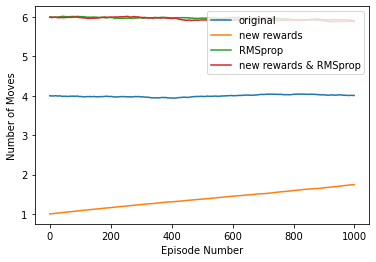

In [13]:
# Exponential moving average of number of moves per game over time
plt.plot(n1)
plt.plot(n2)
plt.plot(n3)
plt.plot(n4)

plt.legend(['original', 'new rewards', 'RMSprop', 'new rewards & RMSprop'], loc='upper right')
plt.xlabel('Episode Number')
plt.ylabel('Number of Moves')
plt.show()